In [1]:
# =============================================
#   CellMap nucleus-related segmentation (Multi-Crop K-Fold)
#   Classes: 20,21,22,23,24,28,35
#   Author: Gemini
#   TU Dresden - CMS Research Project
# =============================================

import os
import json
import numpy as np # type: ignore
import time
import zarr  # type: ignore
from tqdm import tqdm  # type: ignore
import matplotlib.pyplot as plt  # type: ignore
import random
from datetime import datetime
from scipy.ndimage import gaussian_filter, sobel, laplace  # type: ignore
from sklearn.ensemble import RandomForestClassifier  # type: ignore
from sklearn.model_selection import KFold  # type: ignore
from sklearn.metrics import jaccard_score, f1_score  # type: ignore

# ---------------------------------------------
# Step 1. Setup paths (MODIFIED)
# ---------------------------------------------

# Define all Crop IDs to be used in the K-Fold cross-validation (5 crops for 5-fold)
# CROP_IDS = ["crop292", "crop234", "crop236", "crop237", "crop239"]
CROP_IDS = ["crop292"]
# If you need 7-fold: CROP_IDS = ["crop292", "crop234", "crop236", "crop237", "crop239", "crop243", "crop247"]

RAW_S0 = r"../data/jrc_cos7-1a/jrc_cos7-1a.zarr/recon-1/em/fibsem-uint8/s0"
GROUNDTRUTH_ROOT = r"../data/jrc_cos7-1a/jrc_cos7-1a.zarr/recon-1/labels/groundtruth"

# 5 classes for segmentation
SELECT_CLASSES = {
    "cyto": 35,
    "mito_mem": 3,
    "mito_lum": 4,
    "er_mem": 16,
    "er_lum": 17,
}

# Multi-class mapping: background=0
CLASS_ID_MAP = {
    "cyto": 1,
    "mito_mem": 2,
    "mito_lum": 3,
    "er_mem": 4,
    "er_lum": 5,
}

# Class name list for printing results (order MUST match labels_eval)
CLASS_NAMES_ORDERED = ["cyto", "mito_mem", "mito_lum", "er_mem", "er_lum"]
labels_eval = [1, 2, 3, 4, 5] # The 5 target class IDs

REF_CLASS = "nucpl" # Used to determine the bounds/shape of each crop

raw_zarr = zarr.open(RAW_S0, mode="r")
print("Raw shape:", raw_zarr.shape)

Raw shape: (1813, 4368, 20609)


In [39]:
import numpy as np
from scipy.ndimage import gaussian_filter, sobel, gaussian_laplace

def extract_full_3d_features(vol_3d):
    """
    Final feature set (Z, Y, X, 9)

    0 Raw
    1 Gaussian s=1
    2 Gaussian s=2
    3 Local Variance s=2
    4 StdDev s=3
    5 GradMag s=2
    6 GradMag s=3
    7 DoG s=2-6
    """
    # Normalize
    img = vol_3d.astype(np.float32) / 255.0
    features = []

    # --- Gaussians ---
    g1 = gaussian_filter(img, sigma=1.0)
    g2 = gaussian_filter(img, sigma=2.0)
    g3 = gaussian_filter(img, sigma=3.0)
    g6 = gaussian_filter(img, sigma=6.0)

    # 0–2: Raw + Gaussian
    features.append(img)
    features.append(g1)
    features.append(g2)

    # 3: Local Variance (σ=2)
    mean_sq_2 = gaussian_filter(img * img, sigma=2.0)
    local_var = mean_sq_2 - g2 * g2
    features.append(local_var)

    # 4: StdDev (σ=3)
    mean_sq_3 = gaussian_filter(img * img, sigma=3.0)
    var_3 = mean_sq_3 - g3 * g3
    stddev_3 = np.sqrt(np.maximum(var_3, 0.0))
    features.append(stddev_3)

    # 5–6: Gradient Magnitude (XY)
    def gradmag_xy(vol):
        gx = sobel(vol, axis=2)  # X
        gy = sobel(vol, axis=1)  # Y
        return np.sqrt(gx * gx + gy * gy)

    features.append(gradmag_xy(g2))  # s=2
    features.append(gradmag_xy(g3))  # s=3

    # 7: DoG (σ=2–6)
    features.append(g2 - g6)

    return np.stack(features, axis=-1).astype(np.float32)



===== Loading and Aligning Multiple Crops =====

Processing crop292...
  Raw crop shape: (400, 400, 400)
  Unique final multi-class labels in crop292: [0 1 2 3 4 5]

===== Performing Feature Extraction and Merging =====
  Extracting features for crop292...
Total features per voxel: 8
  --- Visualizing all features for the first crop ---


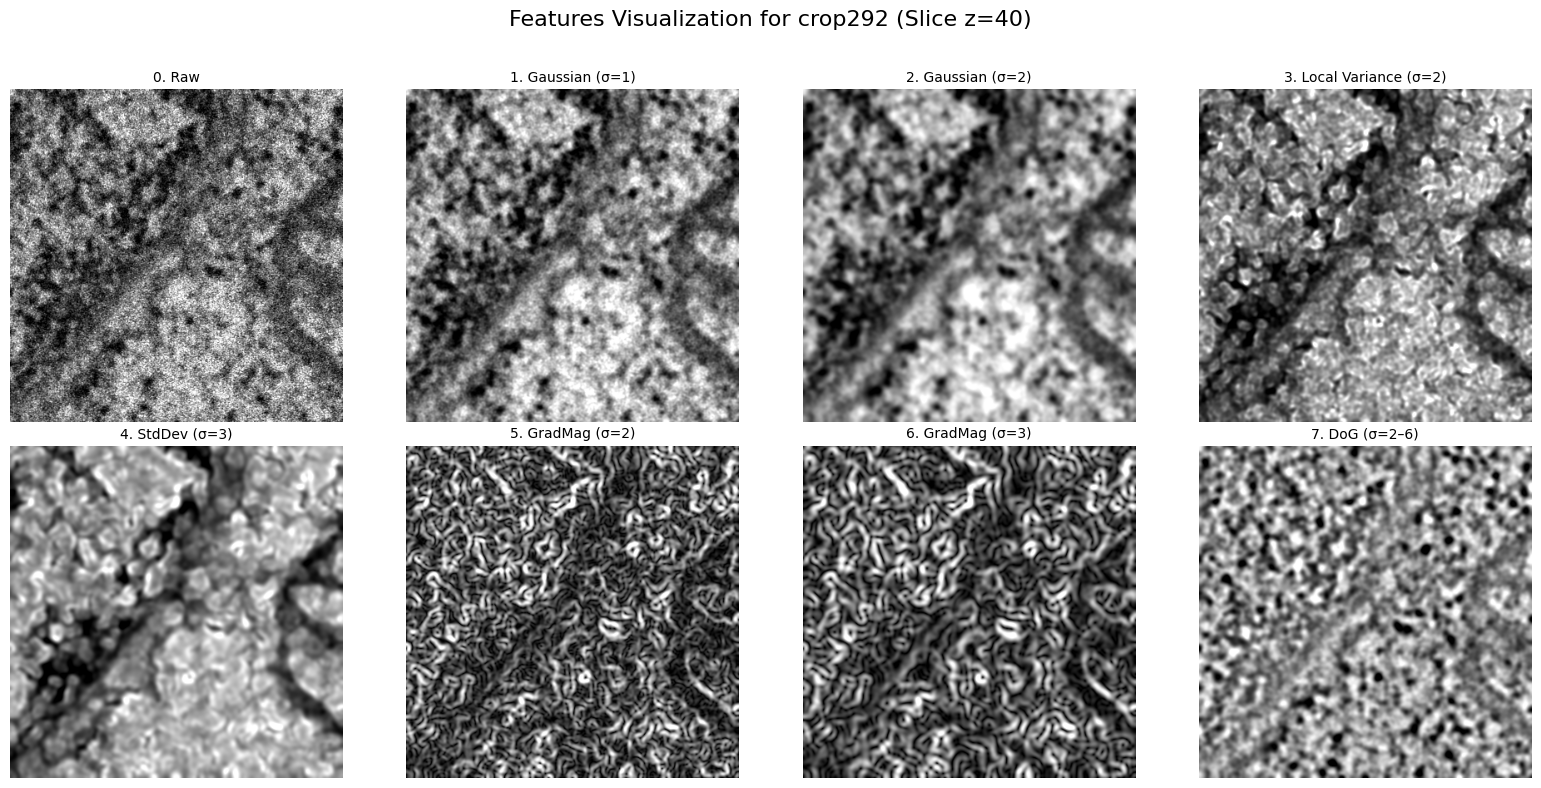

In [40]:
# ============================================================
# Step 2-4: Load multiple crops, align, and store (MODIFIED)
# ============================================================

# List to store the loaded raw data, labels, and metadata for each crop
all_crops_data = []
crop_pixel_counts = []  # Stores total pixels (Dz * Dy * Dx) for each crop

print("\n===== Loading and Aligning Multiple Crops =====")

for crop_id in CROP_IDS:
    print(f"\nProcessing {crop_id}...")
    CROP_ROOT = os.path.join(GROUNDTRUTH_ROOT, crop_id)
    REF_S0 = os.path.join(CROP_ROOT, REF_CLASS, "s0")
    REF_ZATTR = os.path.join(CROP_ROOT, REF_CLASS, ".zattrs")

    # Open reference zarr to get shape
    ref_zarr = zarr.open(REF_S0, mode="r")
    Dz, Dy, Dx = ref_zarr.shape

    # --- Step 2. Read .zattrs (translation + scale) ---
    with open(REF_ZATTR, "r") as f:
        attrs = json.load(f)
    ms = attrs["multiscales"][0]["datasets"][0]
    scale = ms["coordinateTransformations"][0]["scale"]
    trans = ms["coordinateTransformations"][1]["translation"]
    scale_z, scale_y, scale_x = scale
    tz, ty, tx = trans

    # --- Step 3. Convert nm → voxel index & crop raw ---
    vz0 = int(tz / scale_z)
    vy0 = int(ty / scale_y)
    vx0 = int(tx / scale_x)
    vz1, vy1, vx1 = vz0 + Dz, vy0 + Dy, vx0 + Dx

    raw_crop = raw_zarr[vz0:vz1, vy0:vy1, vx0:vx1]
    print(f"  Raw crop shape: {raw_crop.shape}")

    # --- Step 4. Build multi-class label (0–5) ---
    label_multi = np.zeros((Dz, Dy, Dx), dtype=np.uint8)
    for cname, real_id in SELECT_CLASSES.items():
        path = os.path.join(CROP_ROOT, cname, "s0")
        try:
            arr = zarr.open(path, mode="r")[:]
            cid = CLASS_ID_MAP[cname]
            label_multi[arr > 0] = cid
        except Exception as e:
            print(f"  Warning: Failed to load class {cname} in {crop_id}. Error: {e}")

    print(f"  Unique final multi-class labels in {crop_id}: {np.unique(label_multi)}")

    # Store the result and metadata
    all_crops_data.append(
        {"raw": raw_crop, "label": label_multi, "shape": (Dz, Dy, Dx), "id": crop_id}
    )
    crop_pixel_counts.append(Dz * Dy * Dx)

# ============================================================
# Step 5: Full 3D Feature Extraction and Merging (MODIFIED)
# ============================================================
print("\n===== Performing Feature Extraction and Merging =====")

X_all_crops_list = []
y_all_crops_list = []
n_feats = 0  # Initialize feature count

for crop_item in all_crops_data:
    raw_crop = crop_item["raw"]
    label_multi = crop_item["label"]

    print(f"  Extracting features for {crop_item['id']}...")

    # 1. Execute feature extraction on the current 3D volume
    X_vol_4d = extract_full_3d_features(raw_crop)

    # 💥 NEW: Store the 4D feature volume for fast visualization later (Step 9)
    crop_item["features_4d"] = X_vol_4d

    # Get feature count only once
    if n_feats == 0:
        n_feats = X_vol_4d.shape[-1]
        print(f"Total features per voxel: {n_feats}")

        # ============================================================
# ✨ Feature Visualization Code (ROBUST VERSION)
# ============================================================
print("  --- Visualizing all features for the first crop ---")

Dz = raw_crop.shape[0]
vis_z_feat = Dz // 10  # 你现在用的层，OK

feat_slice = X_vol_4d[vis_z_feat, :, :, :]

feature_names = [
    "Raw",
    "Gaussian (σ=1)",
    "Gaussian (σ=2)",
    "Local Variance (σ=2)",
    "StdDev (σ=3)",
    "GradMag (σ=2)",
    "GradMag (σ=3)",
    "DoG (σ=2–6)",
]

if feat_slice.shape[-1] == len(feature_names):
    num_feats = len(feature_names)

    n_cols = 4
    n_rows = int(np.ceil(num_feats / n_cols))

    fig_feat, axes_feat = plt.subplots(
        n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows)
    )
    fig_feat.suptitle(
        f"Features Visualization for {crop_item['id']} (Slice z={vis_z_feat})",
        fontsize=16,
    )

    axes_flat = axes_feat.flatten()

    for f_idx in range(num_feats):
        ax = axes_flat[f_idx]
        feat_map = feat_slice[:, :, f_idx]

        # ===== 🔑 核心：robust normalization =====
        vmin = np.percentile(feat_map, 1)
        vmax = np.percentile(feat_map, 99)

        # 防止极端情况下 vmin == vmax
        if vmax <= vmin:
            vmin, vmax = feat_map.min(), feat_map.max()

        im = ax.imshow(
            feat_map,
            cmap="gray",        # 👈 建议用 gray，看结构最清楚
            vmin=vmin,
            vmax=vmax,
            aspect="equal",
        )

        ax.set_title(f"{f_idx}. {feature_names[f_idx]}", fontsize=10)
        ax.axis("off")

    # 隐藏多余子图
    for j in range(num_feats, n_rows * n_cols):
        fig_feat.delaxes(axes_flat[j])

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

else:
    print("  --- Warning: Feature count mismatch. Skipping feature visualization. ---")

# ============================================================
# ✨ End Feature Visualization Code
# ============================================================


    # 2. Flatten the feature volume and label volume
    X_pixels = X_vol_4d.reshape(-1, n_feats)
    y_pixels = label_multi.reshape(-1)

    X_all_crops_list.append(X_pixels)
    y_all_crops_list.append(y_pixels)

# 3. Concatenate all flattened data into the final training/validation sets
# X_all_flat = np.concatenate(X_all_crops_list, axis=0)  # Total_Pixels x N_features
# y_all_flat = np.concatenate(y_all_crops_list, axis=0)  # Total_Pixels

# print(f"Total merged flat dataset size: {X_all_flat.shape[0]} pixels")

In [ ]:
# ============================================================
# NEW: Function Definition for Pixel Sampling
# ============================================================

def limit_class_pixels(X, y, max_per_class=50000, random_state=42):
    """
    Limit the number of pixels per class to avoid memory explosion and mitigate imbalance.
    """
    np.random.seed(random_state)
    X_list, y_list = [], []
    all_unique_classes = np.unique(y)

    print("\n===== Limiting class sizes =====")

    for c in all_unique_classes:
        idx = np.where(y == c)[0]
        count = len(idx)

        cname = "Background" if c == 0 else CLASS_NAMES_ORDERED[c - 1]
        print(f"Class {c} ({cname}): total {count} pixels")

        if count > max_per_class:
            selected = np.random.choice(idx, max_per_class, replace=False)
            print(f"   -> sampled {max_per_class}")
        else:
            selected = idx
            print(f"   -> kept all {count}")

        X_list.append(X[selected])
        y_list.append(y[selected])

    X_new = np.concatenate(X_list, axis=0)
    y_new = np.concatenate(y_list, axis=0)

    print(f"\nBalanced dataset size: {X_new.shape[0]} pixels")
    return X_new, y_new


# ============================================================
# Step 6: K-fold Cross Validation Setup (MODIFIED)
# ============================================================
# K-Fold split is based on the index of the crops
crop_indices = np.arange(len(CROP_IDS))
kf = KFold(n_splits=len(CROP_IDS), shuffle=True, random_state=42)

# Calculate cumulative pixel count indices to slice X_all_flat and y_all_flat
# This array tells us where each crop starts in the flattened dataset
crop_start_indices = np.cumsum([0] + crop_pixel_counts)

fold_scores = []

# ============================================================
# Step 7: Train & Validate (MODIFIED for Crop-based split & Chunking)
# ============================================================

for fold, (train_crop_idx, val_crop_idx) in tqdm(enumerate(kf.split(crop_indices)), total=kf.n_splits,
                                                 desc="K-Fold Progress"):
    print(f"\n================ FOLD {fold} ================")
    fold_start = time.time()

    # 1. Build Training Set (Concatenate all selected training crops)
    X_train_list, y_train_list = [], []
    for c_idx in train_crop_idx:
        start = crop_start_indices[c_idx]
        end = crop_start_indices[c_idx + 1]
        X_train_list.append(X_all_flat[start:end])
        y_train_list.append(y_all_flat[start:end])

    X_train_full = np.concatenate(X_train_list, axis=0)
    y_train_full = np.concatenate(y_train_list, axis=0)

    # 2. Build Validation Set (Single validation crop)
    val_c_idx = val_crop_idx[0]
    start = crop_start_indices[val_c_idx]
    end = crop_start_indices[val_c_idx + 1]

    X_val = X_all_flat[start:end]
    y_val = y_all_flat[start:end]
    print(f"FOLD {fold}: Validation Crop ID: {CROP_IDS[val_c_idx]}")

    # ------------------------------------------------------------
    # A. Apply pixel limit to the training set (Sampling)
    # ------------------------------------------------------------
    # 假设使用 50000 像素作为测试限制
    PIXEL_LIMIT = 50000
    print(f"FOLD {fold}: Applying pixel limit of {PIXEL_LIMIT} per class to training data...")
    X_train, y_train = limit_class_pixels(
        X_train_full,
        y_train_full,
        max_per_class=PIXEL_LIMIT,
        random_state=42 + fold
    )

    print(f"Fold {fold} Sampled Train set shape:", X_train.shape)
    print(f"Fold {fold} Val set shape:  ", X_val.shape)

    # ============================================================
    # Step C: Train RandomForest 🌳
    # ============================================================
    print("Training RandomForest...")
    clf = RandomForestClassifier(n_estimators=100, class_weight="balanced", n_jobs=2, random_state=42)
    clf.fit(X_train, y_train)

    # ============================================================
    # Step D & E: Predict & Evaluate (USING CHUNKING)
    # ============================================================
    print("Predicting...")

    # --- NEW: Predict in Chunks to avoid OOM ---
    chunk_size = 8000000  # 800万像素点一个批次
    y_pred_list = []
    n_pixels = X_val.shape[0]
    n_chunks = int(np.ceil(n_pixels / chunk_size))

    for i in tqdm(range(n_chunks), desc="Predicting Chunks"):
        start_idx = i * chunk_size
        end_idx = min((i + 1) * chunk_size, n_pixels)

        X_chunk = X_val[start_idx:end_idx]

        # 使用训练好的模型对小块进行预测
        y_pred_chunk = clf.predict(X_chunk)
        y_pred_list.append(y_pred_chunk)

    # 将所有小块的预测结果拼接回完整的预测结果
    y_pred = np.concatenate(y_pred_list, axis=0)
    print(f"Prediction complete. Final shape: {y_pred.shape}")
    # ------------------------------------------------------------

    # Calculate scores PER CLASS for the 5 target classes
    iou_per_class = jaccard_score(y_val, y_pred, average=None, labels=labels_eval, zero_division=0)
    dice_per_class = f1_score(y_val, y_pred, average=None, labels=labels_eval, zero_division=0)

    iou_macro = np.mean(iou_per_class)
    dice_macro = np.mean(dice_per_class)

    print(f"FOLD {fold} Result: IoU_macro={iou_macro:.4f}, Dice_macro={dice_macro:.4f}")

    # Store results
    fold_scores.append({
        'iou_macro': iou_macro,
        'dice_macro': dice_macro,
        'iou_per_class': iou_per_class,
        'dice_per_class': dice_per_class
    })

    elapsed = time.time() - fold_start
    print(f"⏱ Fold {fold} took {elapsed / 60:.2f} minutes")


# ============================================================
# Step 7.5: Train final model on ALL data (Balanced Sampling) (MINOR MODIFICATION)
# ============================================================

print("\n===== Step 7.5: Training final model on ALL data (Balanced Sampling) =====")

# Apply the sampling to the full dataset (X_all_flat, y_all_flat)
X_sub, y_sub = limit_class_pixels(X_all_flat, y_all_flat, max_per_class=50000)

print("Training FINAL RandomForest model...")

final_clf = RandomForestClassifier(
    n_estimators=100,
    class_weight="balanced",
    n_jobs=2,  # Use all cores
    random_state=42,
)

final_clf.fit(X_sub, y_sub)

print("🎉 Final model training complete!")

# ============================================================
# Step 8: Print final aggregated results (NO CHANGE)
# ============================================================
print("\n================ Final K-fold Results ================\n")

# Aggregate per-class scores across all folds
all_iou_per_class = np.array([s['iou_per_class'] for s in fold_scores])
all_dice_per_class = np.array([s['dice_per_class'] for s in fold_scores])

# Calculate average per-class scores
avg_iou_per_class = np.mean(all_iou_per_class, axis=0)
avg_dice_per_class = np.mean(all_dice_per_class, axis=0)

# Print detailed results per fold
for k, scores in enumerate(fold_scores):
    print(f"Fold {k}:   IoU_macro={scores['iou_macro']:.4f}   Dice_macro={scores['dice_macro']:.4f}")

print("\n---------------- Detailed Class Averages ----------------")
print("Class | Avg IoU (Jaccard) | Avg Dice (F1)")
print("------|-------------------|---------------")
for i, cname in enumerate(CLASS_NAMES_ORDERED):
    print(f"{cname:6s}| {avg_iou_per_class[i]:.4f} | {avg_dice_per_class[i]:.4f}")

    # Calculate final macro averages
avg_macro_iou = np.mean(avg_iou_per_class)
avg_macro_dice = np.mean(avg_dice_per_class)

print("\n================ Aggregated Macro Scores ================")
print(f"Average Macro IoU (5 classes): {avg_macro_iou:.4f}")
print(f"Average Macro Dice (5 classes): {avg_macro_dice:.4f}")

# ============================================================
# Step 9: Save 10 random prediction slices per crop (MODIFIED)
# ============================================================

# ---- 1. Determine the next experiment number (i) ----
result_root = "../Result"
os.makedirs(result_root, exist_ok=True)
existing_dirs = [d for d in os.listdir(result_root) if d.startswith("predict")]
max_i = 0
for d in existing_dirs:
    try:
        # Extract the number 'i' from 'predict(i)'
        # Handles both 'predict(1)' and 'predict1' formats, focusing on extracting the number
        num_str = ''.join(filter(str.isdigit, d))
        if num_str:
            max_i = max(max_i, int(num_str))
    except:
        continue  # Ignore non-standard directories

next_i = max_i + 1
experiment_folder = os.path.join(result_root, f"predict({next_i})")
os.makedirs(experiment_folder, exist_ok=True)

print(f"\nSaving visualizations into new experiment folder: {experiment_folder}")

# ---- 2. Iterate through all crops and save 10 random slices each ----
num_vis_per_crop = 10

# Convert all_crops_data list into a dictionary for easy access by crop_id
crops_data_dict = {item['id']: item for item in all_crops_data}

# Use the final_clf trained on all balanced data
if 'final_clf' not in locals():
    print("Warning: final_clf not found. Skipping visualization.")
else:
    for crop_id in CROP_IDS:
        crop_item = crops_data_dict[crop_id]

        # Create the subfolder for the current crop: predict(i)/crop_id
        crop_save_folder = os.path.join(experiment_folder, crop_id)
        os.makedirs(crop_save_folder, exist_ok=True)

        print(f"\n--- Processing {crop_id} (Saving {num_vis_per_crop} slices) ---")

        raw_crop_vis = crop_item['raw']
        label_multi_vis = crop_item['label']
        Dz, Dy, Dx = crop_item['shape']

        # Retrieve the pre-computed 4D feature volume
        # We rely on 'features_4d' being added in Step 5
        feat_vol_4d = crop_item['features_4d']

        # Select 10 unique random Z slices
        if Dz < num_vis_per_crop:
            vis_zs = range(Dz)  # Use all slices if less than 10
            print(f"Crop Z size ({Dz}) is less than 10, visualizing all slices.")
        else:
            vis_zs = random.sample(range(Dz), num_vis_per_crop)

        for i, vis_z in enumerate(vis_zs):
            # 3. Predict on the slice
            feat_vis_slice = feat_vol_4d[vis_z, :, :, :]
            X_vis = feat_vis_slice.reshape(-1, n_feats)
            y_pred_vis = final_clf.predict(X_vis).reshape(Dy, Dx)

            # GT & raw (retrieve original data)
            y_gt_vis = label_multi_vis[vis_z]
            raw_vis = raw_crop_vis[vis_z]

            # ---- Visualization ----
            fig = plt.figure(figsize=(18, 6))

            plt.suptitle(f"Exp: {next_i} | Crop: {crop_id}, Slice z={vis_z}", fontsize=16)

            # --- Raw ---
            plt.subplot(1, 3, 1)
            plt.title("Raw")
            plt.imshow(raw_vis, cmap='gray')
            plt.axis("off")

            # --- Ground Truth ---
            plt.subplot(1, 3, 2)
            plt.title("Ground Truth")
            # Ensure the color map handles the range 0-5
            plt.imshow(y_gt_vis, cmap="tab10", vmin=0, vmax=9)
            plt.axis("off")

            # --- Prediction ---
            plt.subplot(1, 3, 3)
            plt.title("Prediction")
            plt.imshow(y_pred_vis, cmap="tab10", vmin=0, vmax=9)
            plt.axis("off")

            plt.tight_layout(rect=[0, 0, 1, 0.94])

            # Save image
            # Filename: slice_001_z123.png
            save_path = os.path.join(crop_save_folder, f"slice_{i + 1:02d}_z{vis_z:04d}.png")
            plt.savefig(save_path, dpi=200)
            plt.close()

            print(f"  [{i + 1}/{len(vis_zs)}] Saved: {save_path}")

    print("\n--- Script Finished ---")